# Project Group - 22

Members: Charlotte Koning, Cleo Vos, Koen Awater, Jasmijn van de Kar, Jippo Steenstra

Student numbers: 5414164, 5324599, 5416493, 5315611, 5064740

# Research Objective

*Requires data modeling and quantitative research in Transport, Infrastructure & Logistics*

Main Research Question:

To what extent can anomalous peaks in pedestrian flow be predicted up to 15 minutes in advance using historical sensor data and temporal features?

Sub questions:
1.	How can anomalous crowd behaviour be quantitatively defined within the dataset?
2.	Which sensor locations show the highest likelihood of anomalies?
3.	How accurately can different models (e.g., Logistic Regression, Random Forest, XGBoost) predict anomalies?
4.	Which features (temporal, spatial, or meteorological) contribute most to prediction accuracy?

# Contribution Statement

Be specific. Some of the tasks can be coding (expect everyone to do this), background research, conceptualisation, visualisation, data analysis, data modelling

**Author 1**:

**Author 2**:

**Author 3**:

# Data Used

We will use the dataset(s) about the SAIL event, provided by the professors.

# Data Pipeline

For the geographical scale we will use eastern harbor of Amsterdam IJhaven, across the IJ river. The temporal scale of the project will be the 20-24 august 2025. For data preperation we will use the Panda library in python.

In [62]:
import pandas as pd
import chardet
import os
import matplotlib.pyplot as plt
import calendar
import numpy as np
from scipy.interpolate import make_interp_spline

In [63]:
flow_file = 'SAIL2025_LVMA_data_3min_20August-25August2025_flow.csv'
location_file = 'sensor-location.xlsx'

with open(flow_file, 'rb') as f:
    result = chardet.detect(f.read())

enc = result['encoding']

df_flow = pd.read_csv(flow_file, encoding=enc)


with open(location_file, 'rb') as f:
    result = chardet.detect(f.read())


df_location = pd.read_excel(location_file)

In [64]:
df_flow.head(3)


,timestamp,CMSA-GAKH-01_0,CMSA-GAKH-01_180,CMSA-GAWW-11_120,CMSA-GAWW-11_300,CMSA-GAWW-12_115,CMSA-GAWW-12_295,CMSA-GAWW-13_120,CMSA-GAWW-13_300,CMSA-GAWW-14_40,...,GVCV-13_10,GVCV-13_190,GVCV-14_90,GVCV-14_270,hour,minute,day,month,weekday,is_weekend
0,2025-08-20 00:00:00+02:00,15,4,29,33,44,28,42,37,11,...,41,40,0,0,0,0,20,8,2,0
1,2025-08-20 00:03:00+02:00,1,3,21,29,34,39,9,14,6,...,0,0,0,0,0,3,20,8,2,0
2,2025-08-20 00:06:00+02:00,5,4,35,22,29,34,33,42,14,...,0,0,0,0,0,6,20,8,2,0


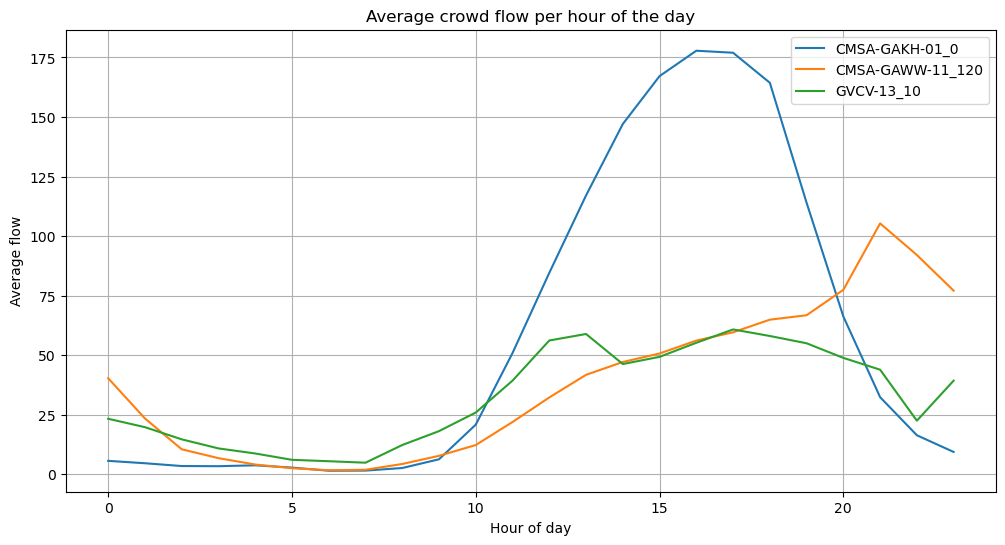

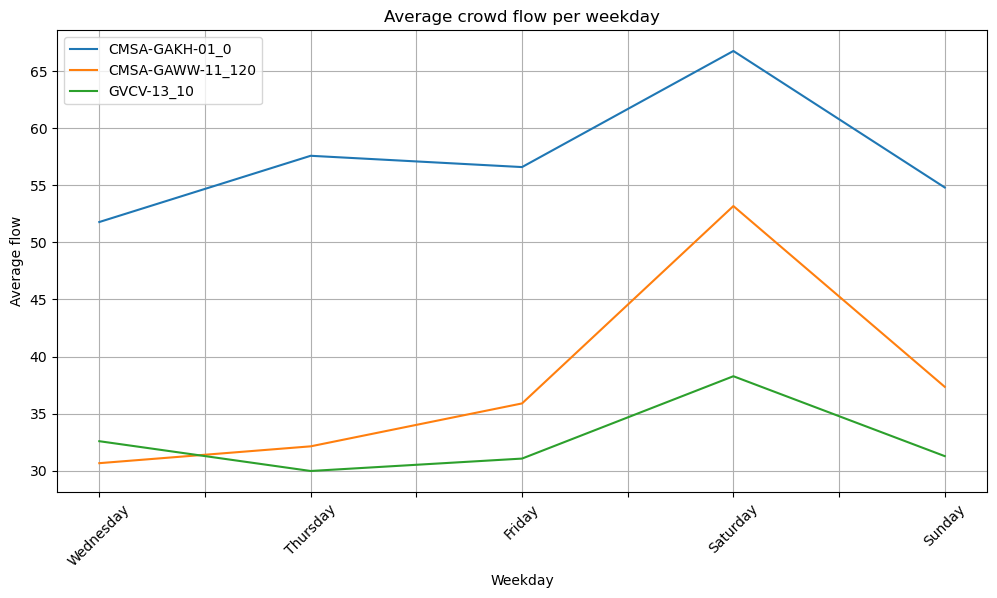

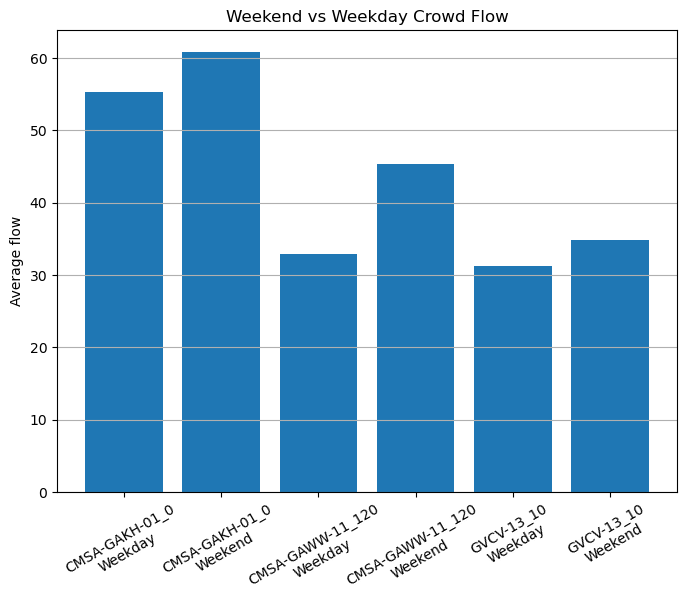

In [65]:
sensors = ["CMSA-GAKH-01_0", "CMSA-GAWW-11_120", "GVCV-13_10"]

# 1. Hourly plot (unchanged)
plt.figure(figsize=(12, 6))
for sensor in sensors:
    df_flow.groupby("hour")[sensor].mean().plot(label=sensor)
plt.title("Average crowd flow per hour of the day")
plt.xlabel("Hour of day")
plt.ylabel("Average flow")
plt.legend()
plt.grid(True)
plt.show()

# 2. Weekday plot with names instead of numbers
# Create mapping: 0 = Monday, 6 = Sunday
weekday_names = [calendar.day_name[i] for i in range(7)]

plt.figure(figsize=(12, 6))
for sensor in sensors:
    weekday_means = df_flow.groupby("weekday")[sensor].mean()
    weekday_means.index = [weekday_names[i] for i in weekday_means.index]
    weekday_means.plot(label=sensor)

plt.title("Average crowd flow per weekday")
plt.xlabel("Weekday")
plt.ylabel("Average flow")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# 3. Weekend vs Weekday bar plot
plt.figure(figsize=(8, 6))
means = []
labels = []
for sensor in sensors:
    weekend_mean = df_flow[df_flow["is_weekend"] == 1][sensor].mean()
    weekday_mean = df_flow[df_flow["is_weekend"] == 0][sensor].mean()
    means.extend([weekday_mean, weekend_mean])
    labels.extend([f"{sensor}\nWeekday", f"{sensor}\nWeekend"])

plt.bar(labels, means)
plt.title("Weekend vs Weekday Crowd Flow")
plt.ylabel("Average flow")
plt.xticks(rotation=30)
plt.grid(axis='y')
plt.show()


📡 Plotting sensor: GASA-01-C_315


C:\Users\kawat\AppData\Local\Temp\ipykernel_21516\1200038627.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("5T").mean()
C:\Users\kawat\AppData\Local\Temp\ipykernel_21516\1200038627.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(start=start, end=end, freq="5T")


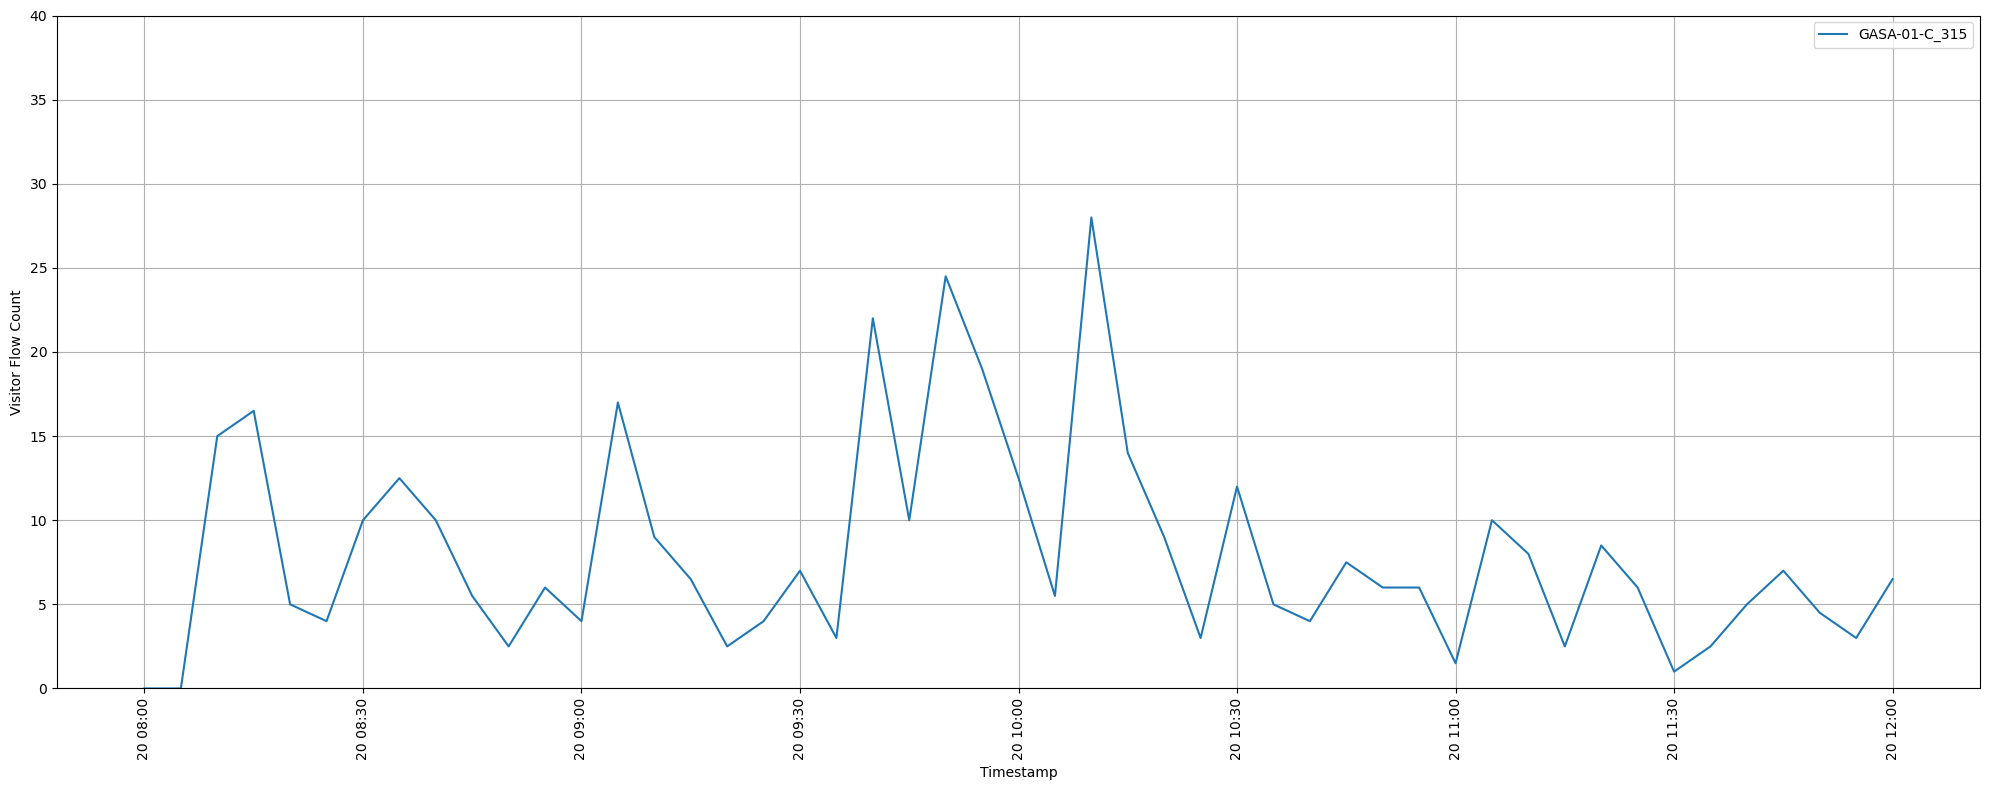

In [74]:
sensor_columns = [c for c in df_flow.columns
                  if c not in ["timestamp","hour","minute","day","month","weekday","is_weekend"]]
random_sensor = np.random.choice(sensor_columns)
print(f"📡 Plotting sensor: {random_sensor}")

df_flow["timestamp"] = pd.to_datetime(df_flow["timestamp"])
df_flow = df_flow.sort_values("timestamp")

series = (
    df_flow.set_index("timestamp")[random_sensor]
           .resample("5T").mean()   
)

day0 = series.index.normalize()[0]
start = day0 + pd.Timedelta(hours=8)
end   = day0 + pd.Timedelta(hours=12)
window = series.loc[start:end]

full_index = pd.date_range(start=start, end=end, freq="5T")  

plt.figure(figsize=(20, 8))
plt.plot(window.index, window.values, label=random_sensor, linewidth=1.5)  
plt.xlabel("Timestamp")
plt.ylabel("Visitor Flow Count")
plt.xticks(rotation=90)

ymax = 20 * int(np.ceil((np.nanmax(window.values) if np.isfinite(np.nanmax(window.values)) else 0) / 20.0))
plt.ylim(0, max(20, ymax))

plt.grid(True)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


In [67]:
#sklearn